In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, auc, roc_curve, confusion_matrix

## Data Preparation

In [2]:
df = pd.read_csv('../dataproject2025.csv')
df = df.dropna()

In [3]:
X_cols = ['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length',
       'emp_title', 'fico_range_high', 'funded_amnt', 'grade',
       'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
       'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'revol_bal', 'revol_util', 'sub_grade',
       'tax_liens', 'zip_code', 'Pct_afro_american']

X = df[X_cols]
y = df['Predictions']

In [4]:
numerical = ['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'fico_range_high', 'funded_amnt', 
       'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
       'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'tax_liens', 'zip_code', 'Pct_afro_american']

category = ['emp_length',
       'emp_title',
       'grade',
       'home_ownership',
       'purpose',
       'sub_grade',
       ]

In [5]:
#FIXME - this should technically be an import from utils.py
def categorical_encoding(df: pd.DataFrame) -> pd.DataFrame:
  """Encodings of categorical variables."""

  df_encoded = df.copy()

  # grade to numeric
  grade_map = {c: i+1 for i, c in enumerate(string.ascii_uppercase[:7])}
  df_encoded["grade_num"] = df_encoded["grade"].map(grade_map)

  # sub_grade to numeric
  sg = df_encoded["sub_grade"].astype(str).str.upper().str.strip()
  letter = sg.str[0]
  number = pd.to_numeric(sg.str[1:].str.extract(r"(\d+)", expand=False), errors="coerce")
  letter_map = {ch: i+1 for i, ch in enumerate("ABCDEFG")}
  base = letter.map(letter_map)
  sub_grade_num = (base - 1) * 5 + number
  df_encoded["sub_grade_num"] = sub_grade_num.astype("float32")

  # emp_length to numeric; map prob cleanest; maybe 10+ different?
  emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
  }

  df_encoded["emp_length_num"] = df_encoded["emp_length"].map(emp_length_map).astype("float32")

  # one-hot
  onehot_cols = ["home_ownership", "purpose", "emp_title"]
  df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, prefix=onehot_cols, drop_first=True)

  # drop originals
  df_encoded = df_encoded.drop(columns=["grade", "sub_grade", "emp_length"])

  return df_encoded

In [6]:
X_encoded = categorical_encoding(X).reset_index(drop=True)
X_encoded.shape, y.shape

((1085789, 96), (1085789,))

## Logistic Regression

In [7]:
logreg = LogisticRegression(max_iter=3000)
logreg.fit(X_encoded, y)

/opt/homebrew/Caskroom/miniforge/base/envs/step1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,3000
,multi_class,'deprecated'


In [8]:
df['surrogate_preds_proba'] = logreg.predict_proba(X_encoded)[:, 1] #probs of 1
df['surrogate_preds'] = logreg.predict(X_encoded)

### Evaluating the surrogate

In [9]:
df['surrogate_preds'].value_counts()

surrogate_preds
0.0    1085789
Name: count, dtype: int64

In [12]:
fpr, tpr, thresholds = roc_curve(df['Predictions'], df['surrogate_preds'])

print(f"AUC: {auc(fpr, tpr)}")
print(f"Accuracy score: {accuracy_score(df['Predictions'], df['surrogate_preds'])}")
print(f"Confusion matrix: {confusion_matrix(df['Predictions'], df['surrogate_preds'])}")
print(f"Mean squared error: {np.sqrt(mean_squared_error(df['Predicted probabilities'], df['surrogate_preds_proba']))}")

AUC: 0.5
Accuracy score: 0.8112966699791581
Confusion matrix: [[880897      0]
 [204892      0]]
Mean squared error: 0.11923596565740742


### Interpreting the model

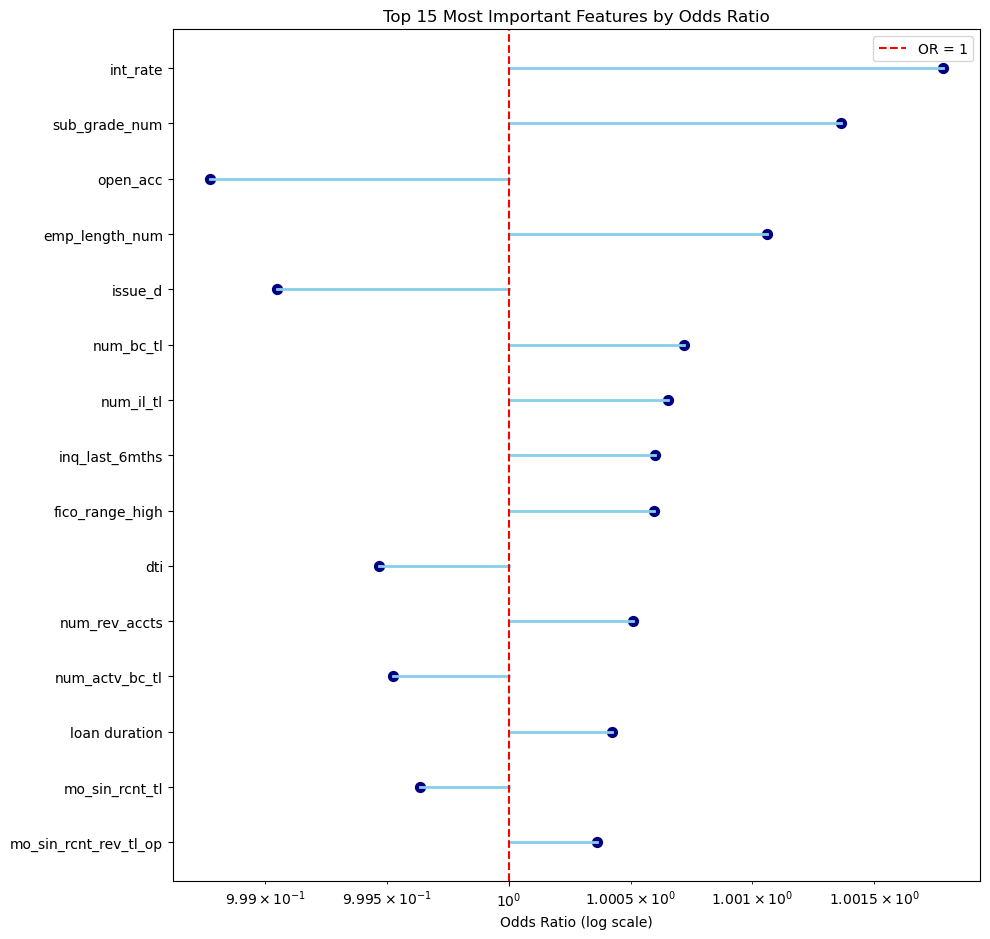

In [13]:
summary = pd.DataFrame({
    'feature': X_encoded.columns,
    'coeff': logreg.coef_[0],
    'odds_ratio': np.exp(logreg.coef_[0])
})
summary['importance'] = np.abs(np.log(summary['odds_ratio']))
summary = summary.sort_values('importance', ascending=False)

top_n = 15
top_summary = summary.head(15)

plt.figure(figsize=(10, 0.5 * top_n + 2))

for i, (feature, or_val) in enumerate(zip(top_summary['feature'], top_summary['odds_ratio'])):
    plt.plot([1, or_val], [i, i], color='skyblue', linewidth=2)
    plt.scatter(or_val, i, color='navy', s=50)

plt.axvline(x=1, color='red', linestyle='--', label='OR = 1')
plt.yticks(range(len(top_summary)), top_summary['feature'])
plt.xscale('log')
plt.xlabel('Odds Ratio (log scale)')
plt.title(f'Top {top_n} Most Important Features by Odds Ratio')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

## Custom PLTR

In [14]:
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd

class PLTR(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=80, max_depth=3, random_state=None, granularity=2, k=5, feature_names=None):
        self.granularity = granularity #how much the rounding should be
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees_ = []
        self.k = k
        self.feature_names = feature_names

    # def tree_fit(self, X, y):
    #     self.trees_ = []
    #     for i in range(self.n_estimators):
    #         tree = DecisionTreeClassifier(
    #             max_depth=self.max_depth,
    #             random_state=None if self.random_state is None else self.random_state + i
    #         )
    #         tree.fit(X, y)
    #         self.trees_.append(tree)
    #     return self
    
    def tree_fit(self, X, y):
        #boosting
        n_features = X.shape[1]
        n_hide = int(np.sqrt(n_features))
        self.trees_ = []
        self.hidden_features_ = []

        rng = np.random.RandomState(self.random_state)

        for i in range(self.n_estimators):
            # pick features to hide
            hide_idx = rng.choice(n_features, size=n_hide, replace=False)

            # make a copy and zero out hidden features
            X_mod = X.copy()
            X_mod.iloc[:, hide_idx] = 0  

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                random_state=None if self.random_state is None else self.random_state + i
            )
            tree.fit(X_mod, y)

            self.trees_.append(tree)
            self.hidden_features_.append(hide_idx)

        return self

    def tree_predict(self, X):
        preds = [tree.predict(X) for tree in self.trees_]
        return sum(preds) / len(preds)

    def identify(self, k=5, feature_names=None):
        """
        Identify the most common (root split, child split) pairs across trees.

        Parameters
        ----------
        k : int
            Number of most common split pairs to return.
        feature_names : list, optional
            Names of features. If None, indices are returned.
        """
        pair_counter = Counter()

        for tree in self.trees_:
            t = tree.tree_

            # Root node
            

            if t.feature[0] != -2:  # -2 means leaf
                f_root = t.feature[0]
                thr_root = round(t.threshold[0], self.granularity)
                f_root_name = feature_names[f_root] if feature_names is not None else f_root

                # Look at children
                for child in [t.children_left[0], t.children_right[0]]:
                    if child != -1 and t.feature[child] != -2:
                        f_child = t.feature[child]
                        thr_child = round(t.threshold[child], self.granularity)
                        f_child_name = feature_names[f_child] if feature_names is not None else f_child

                        pair_counter[((f_root_name, thr_root), (f_child_name, thr_child))] += 1

        #print(pair_counter)

        self.pairs_identified = pair_counter.most_common(k)
        self.pairs_identified = [pair for pair, count in self.pairs_identified]
        return self.pairs_identified
    

    def create_binary_vars(self, X, split_pairs, feature_names=None):
        """
        Create binary variables from root-child split pairs.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data.
        split_pairs : list of tuples
            Each element is ((root_feature, root_thr), (child_feature, child_thr)).
        feature_names : list, optional
            Names of features. If None, indices are used.
            
        Returns
        -------
        df_bin : pd.DataFrame
            DataFrame with 2 binary variables per pair.
        """
        X = np.array(X)
        n_samples = X.shape[0]
        df_bin = pd.DataFrame()
        
        for i, ((f_root, thr_root), (f_child, thr_child)) in enumerate(split_pairs):
            # Get feature indices if names are provided
            # f_root_idx = feature_names.index(f_root) if feature_names else f_root
            # f_child_idx = feature_names.index(f_child) if feature_names else f_child
            f_root_idx = f_root
            f_child_idx = f_child
            
            # Binary var 1: root split
            bin1 = (X[:, f_root_idx] > thr_root).astype(int)
            
            # Binary var 2: child split only where bin1 == 0
            bin2 = np.zeros(n_samples, dtype=int)
            mask = bin1 == 0
            bin2[mask] = (X[mask, f_child_idx] > thr_child).astype(int)
            
            df_bin[f"{feature_names[f_root]} > {thr_root}"] = bin1
            df_bin[f"{feature_names[f_root]} < {thr_root}x{feature_names[f_child]} > {thr_child}"] = bin2
        
        self.modified_df = df_bin
        return self.modified_df

    def fit(self, X, y, adaptive_lasso=False):

        if adaptive_lasso:
            self.tree_fit(X, y)
            self.identify(k=self.k)
            self.create_binary_vars(X, self.pairs_identified, feature_names=self.feature_names)
            modified_input_full = pd.concat([X, self.modified_df], axis=1)

            lr = LogisticRegression(penalty="l2", solver="liblinear", max_iter=3000)
            lr.fit(modified_input_full, y)

            theta0 = lr.coef_.flatten()
            self.weights_alasso = np.power(np.abs(theta0) + 1e-6, -1)  
            self.modified_input_full = modified_input_full / self.weights_alasso[np.newaxis, :]

            final_clf = LogisticRegression(penalty="l1", solver="liblinear",
                                        max_iter=3000)
            self.pltr = final_clf.fit(self.modified_input_full, y)

            return self
        
        else:
            self.pltr = LogisticRegression(max_iter=3000)
            self.tree_fit(X, y)
            self.identify(k=self.k)
            self.create_binary_vars(X, self.pairs_identified, feature_names=self.feature_names)
            self.modified_input_full = pd.concat([X_encoded, self.modified_df], axis=1)
            self.pltr.fit(self.modified_input_full, y)
            return self 
    
    def predict(self, X):
        return self.pltr.predict(X)

    def predict_proba(self, X):
        return self.pltr.predict_proba(X)

### No Adaptive Lasso

In [15]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pltr = PLTR(k=5, random_state=10, feature_names=X_encoded.columns)
pltr.fit(X_encoded, y, adaptive_lasso=False)

/opt/homebrew/Caskroom/miniforge/base/envs/step1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,n_estimators,80
,max_depth,3
,random_state,10
,granularity,2
,k,5
,feature_names,Index(['issue...type='object')


In [16]:
pltr.modified_input_full

,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,...,emp_title_teacher,emp_title_technician,emp_title_truck driver,emp_title_vice president,issue_d > 2017.5,issue_d < 2017.5xissue_d > 2014.5,issue_d < 2017.5xissue_d > 2018.5,loan duration > 0.5,loan duration < 0.5xint_rate > 11.35,loan duration < 0.5xinq_last_6mths > 0.5
0,2013.0,0.0,39600.0,1379.0,21564.0,16.1,0.0,2.49,759.0,4800.0,...,False,False,False,False,0,0,0,0,0,1
1,2013.0,0.0,55000.0,9570.0,16473.0,53.9,0.0,22.87,734.0,27050.0,...,False,False,False,False,0,0,0,0,0,0
2,2013.0,0.0,325000.0,53306.0,13901.0,67.1,0.0,18.55,749.0,28000.0,...,False,False,False,False,0,0,0,0,0,1
3,2013.0,0.0,130000.0,36362.0,3567.0,93.0,0.0,13.03,719.0,12000.0,...,False,False,False,False,0,0,0,0,1,1
4,2013.0,1.0,73000.0,24161.0,4853.0,74.7,1.0,23.13,669.0,27600.0,...,False,False,False,False,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085784,2017.0,0.0,75000.0,4419.0,19337.0,49.0,0.0,23.25,684.0,12000.0,...,False,False,False,False,0,1,0,0,1,1
1085785,2017.0,0.0,95000.0,27902.0,14788.0,76.0,1.0,17.60,694.0,30000.0,...,False,False,False,False,0,1,0,0,1,0
1085786,2017.0,1.0,150457.2,22619.0,303.0,90.5,0.0,19.62,704.0,16000.0,...,False,False,False,False,0,1,0,1,0,0
1085787,2017.0,0.0,150000.0,11837.0,4347.0,92.6,0.0,26.03,674.0,30000.0,...,False,False,False,False,0,1,0,0,1,1


In [17]:
pltr_pred = pltr.predict(pltr.modified_input_full)
pltr_pred_prob = pltr.predict_proba(pltr.modified_input_full)[:, 1]

In [18]:
fpr, tpr, thresholds = roc_curve(df['Predictions'], pltr_pred)

print(f"AUC: {auc(fpr, tpr)}")
print(f"Accuracy score: {accuracy_score(df['Predictions'], pltr_pred)}")
print(f"Confusion matrix: {confusion_matrix(df['Predictions'], pltr_pred)}")
print(f"Mean squared error: {np.sqrt(mean_squared_error(df['Predicted probabilities'], pltr_pred_prob))}")

AUC: 0.5
Accuracy score: 0.8112966699791581
Confusion matrix: [[880897      0]
 [204892      0]]
Mean squared error: 0.11926108845441744


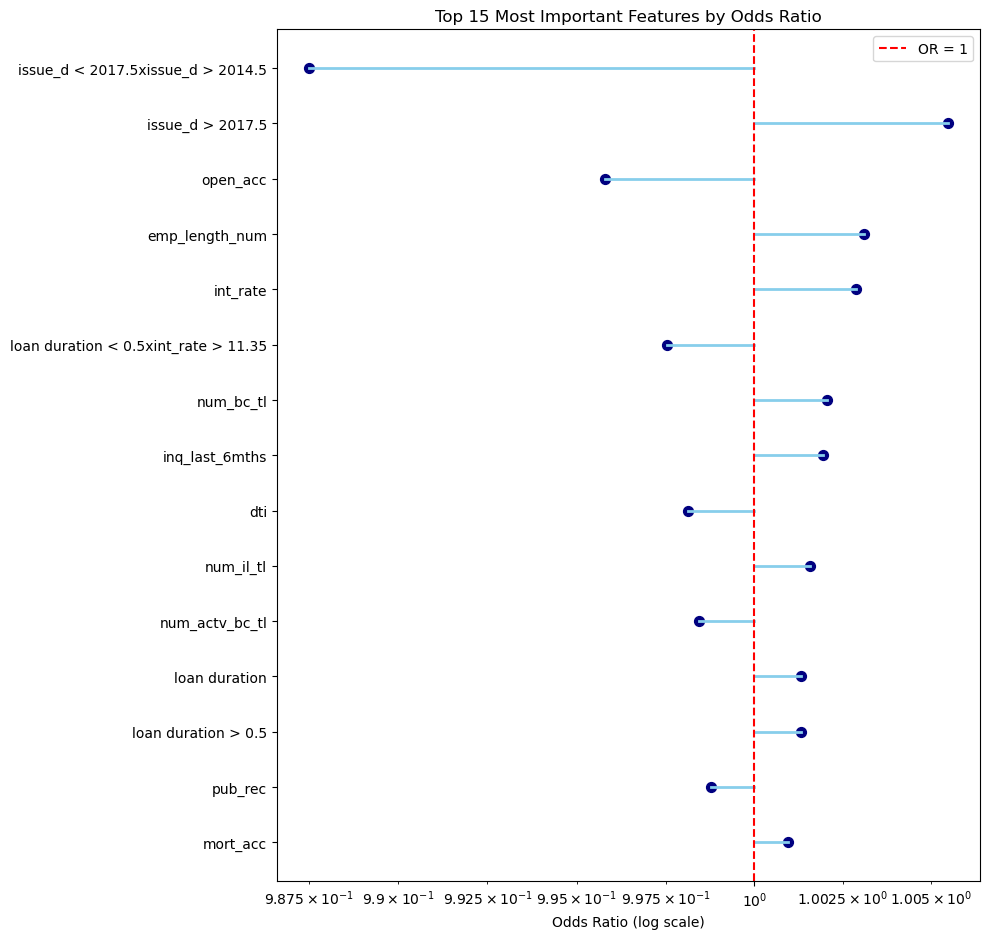

In [19]:
summary = pd.DataFrame({
    'feature': pltr.modified_input_full.columns,
    'coeff': pltr.pltr.coef_[0],
    'odds_ratio': np.exp(pltr.pltr.coef_[0])
})
summary['importance'] = np.abs(np.log(summary['odds_ratio']))
summary = summary.sort_values('importance', ascending=False)

top_n = 15
top_summary = summary.head(15)

plt.figure(figsize=(10, 0.5 * top_n + 2))

for i, (feature, or_val) in enumerate(zip(top_summary['feature'], top_summary['odds_ratio'])):
    plt.plot([1, or_val], [i, i], color='skyblue', linewidth=2)
    plt.scatter(or_val, i, color='navy', s=50)

plt.axvline(x=1, color='red', linestyle='--', label='OR = 1')
plt.yticks(range(len(top_summary)), top_summary['feature'])
plt.xscale('log')
plt.xlabel('Odds Ratio (log scale)')
plt.title(f'Top {top_n} Most Important Features by Odds Ratio')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

### With Adaptive Lasso

In [20]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pltr = PLTR(k=5, random_state=10, feature_names=X_encoded.columns)
pltr.fit(X_encoded, y, adaptive_lasso=True)

KeyboardInterrupt: 

In [21]:
pltr.modified_input_full

AttributeError: 'PLTR' object has no attribute 'modified_input_full'

In [ ]:
pltr_pred = pltr.predict(pltr.modified_input_full)
pltr_pred_prob = pltr.predict_proba(pltr.modified_input_full)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(df['Predictions'], pltr_pred)

print(f"AUC: {auc(fpr, tpr)}")
print(f"Accuracy score: {accuracy_score(df['Predictions'], pltr_pred)}")
print(f"Confusion matrix: {confusion_matrix(df['Predictions'], pltr_pred)}")
print(f"Mean squared error: {np.sqrt(mean_squared_error(df['Predicted probabilities'], pltr_pred_prob))}")

AUC: 0.5
Accuracy score: 0.8112966699791581
Confusion matrix: [[880897      0]
 [204892      0]]
Mean squared error: 0.11921248378493515


/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_33946/4264464858.py:4: RuntimeWarning: overflow encountered in exp
  'odds_ratio': np.exp(pltr.pltr.coef_[0] * pltr.weights_alasso)
/opt/homebrew/Caskroom/miniforge/base/envs/step1/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


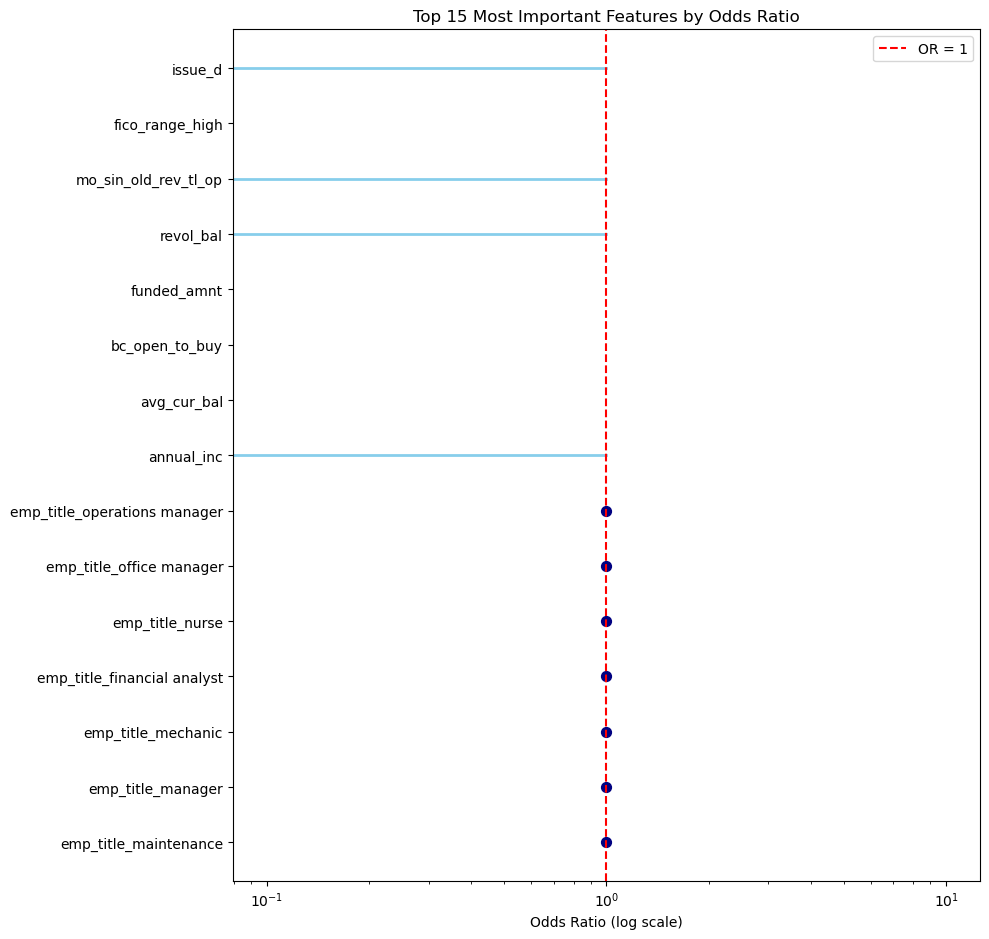

In [ ]:
summary = pd.DataFrame({
    'feature': pltr.modified_input_full.columns,
    'coeff': pltr.pltr.coef_[0] * pltr.weights_alasso,
    'odds_ratio': np.exp(pltr.pltr.coef_[0] * pltr.weights_alasso)
})
summary['importance'] = np.abs(np.log(summary['odds_ratio']))
summary = summary.sort_values('importance', ascending=False)

top_n = 15
top_summary = summary.head(15)

plt.figure(figsize=(10, 0.5 * top_n + 2))

for i, (feature, or_val) in enumerate(zip(top_summary['feature'], top_summary['odds_ratio'])):
    plt.plot([1, or_val], [i, i], color='skyblue', linewidth=2)
    plt.scatter(or_val, i, color='navy', s=50)

plt.axvline(x=1, color='red', linestyle='--', label='OR = 1')
plt.yticks(range(len(top_summary)), top_summary['feature'])
plt.xscale('log')
plt.xlabel('Odds Ratio (log scale)')
plt.title(f'Top {top_n} Most Important Features by Odds Ratio')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()